In [2]:
import torch
from torch import Tensor
import numpy as np
from typing import Set, Iterable, cast, Tuple
from matplotlib import pyplot as plt
from scipy.ndimage import distance_transform_edt

In [9]:
# copy of 'utils.py'
import h5py
import os
from typing import List


def load_data(path: str) -> List[h5py.File]:
    data = []
    for root, dirs, filenames in os.walk(path):
        for file in filenames:
            data.append(h5py.File(f'{root}{file}'))

    return data


def get_raw_at(data: List[h5py.File], index: int) -> np.ndarray:
    return data[index]['raw']


def get_label_at(data: List[h5py.File], index: int) -> np.ndarray:
    return data[index]['label']


def get_raws(data: List[h5py.File]) -> np.ndarray:
    raws = np.zeros(shape=(len(data), *data[0]['raw'].shape), dtype=np.uint8)
    for i in range(len(raws)):
        raws[i] = data[i]['raw']

    return raws


def get_labels(data: List[h5py.File]) -> np.ndarray:
    labels = np.zeros(
        shape=(len(data), *data[0]['label'].shape), dtype=np.uint8)
    for i in range(len(labels)):
        labels[i] = data[i]['label']

    return labels


In [10]:
# Assert utils
def uniq(a: Tensor) -> Set:
    return set(torch.unique(a.cpu()).numpy())

def sset(a: Tensor, sub: Iterable) -> bool:
    return uniq(a).issubset(sub)

def eq(a: Tensor, b) -> bool:
    return torch.eq(a, b).all()

def simplex(t: Tensor, axis=1) -> bool:
    _sum = cast(Tensor, t.sum(axis).type(torch.float32))
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)

def one_hot(t: Tensor, axis=1) -> bool:
    return simplex(t, axis) and sset(t, [0, 1])

In [35]:
def class2one_hot(seg: Tensor, K: int) -> Tensor:
    assert sset(seg, list(range(K))), (uniq(seg), K)

    b, *img_shape = seg.shape  # type: Tuple[int, ...]

    device = seg.device
    res = torch.zeros((b, K, *img_shape), dtype=torch.int64, device=device).scatter_(dim=1, index=seg[:, None, ...], value=1)

    assert res.shape == (b, K, *img_shape)
    assert one_hot(res)

    return res

In [36]:
data = load_data('../challenge_dataset/')
labels = get_labels(data).astype(np.int64)

In [37]:
labels = torch.from_numpy(labels)

In [38]:
labels.dtype

torch.int64

In [39]:
one_hot_labels = class2one_hot(labels, 2)

In [40]:
np_one_hot_labels = one_hot_labels.detach().numpy()

In [41]:
oh_label_0 = np_one_hot_labels[0]

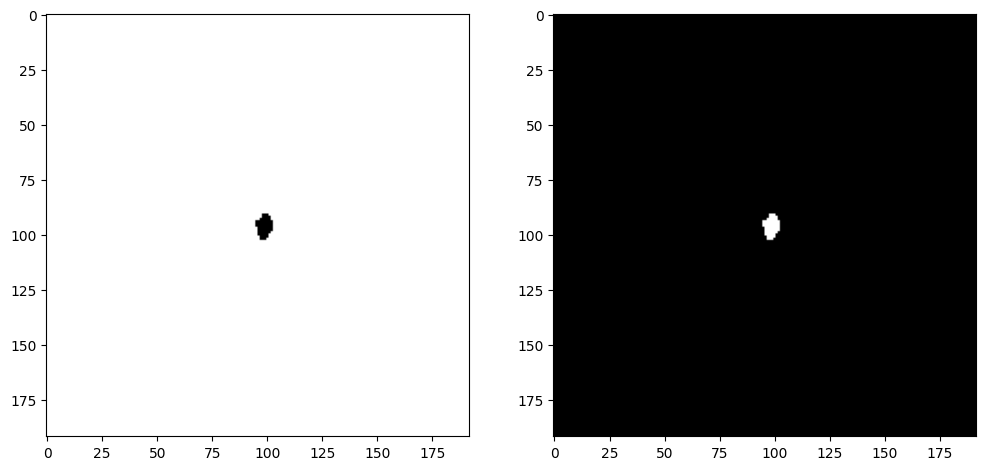

In [45]:
plt.imshow(np.hstack([oh_label_0[0][30], oh_label_0[1][30]]), cmap='gray')
plt.colorbar()

In [46]:
for i in range(64):
    if not np.array_equal(oh_label_0[0][i] + oh_label_0[1][i], np.ones_like(oh_label_0[0][0])):
        print(i)

=> creates positive & negative masks.

In [51]:
def one_hot2dist(seg: np.ndarray, resolution: Tuple[float, float, float] = None,
                 dtype=None) -> np.ndarray:
    assert one_hot(torch.tensor(seg), axis=0)
    K: int = len(seg)

    res = np.zeros_like(seg, dtype=dtype)
    for k in range(K):
        posmask = seg[k].astype(bool)

        if posmask.any():
            negmask = ~posmask
            res[k] = distance_transform_edt(negmask, sampling=resolution) * negmask \
                - (distance_transform_edt(posmask, sampling=resolution) - 1) * posmask
        # The idea is to leave blank the negative classes
        # since this is one-hot encoded, another class will supervise that pixel

    return res

In [52]:
test_dist = one_hot2dist(oh_label_0, resolution=(3., 1., 1.))

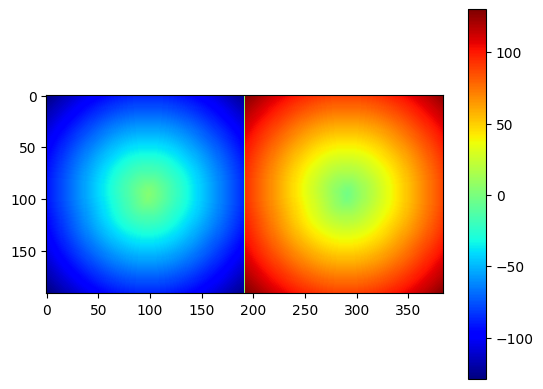

In [58]:
plt.imshow(np.hstack([test_dist[0][30], test_dist[1][30]]), cmap='jet')
plt.colorbar()

In [3]:
from torch.utils.data import DataLoader, Dataset